In [ ]:
!unzip /content/drive/MyDrive/denoised_train.zip

Archive:  /content/drive/MyDrive/denoised_train.zip
   creating: content/denoised_train/
   creating: content/denoised_train/capsule/
   creating: content/denoised_train/capsule/Train/
   creating: content/denoised_train/capsule/Train/Degraded_image/
   creating: content/denoised_train/capsule/Train/Degraded_image/scratch/
  inflating: content/denoised_train/capsule/Train/Degraded_image/scratch/019.png  
  inflating: content/denoised_train/capsule/Train/Degraded_image/scratch/003.png  
  inflating: content/denoised_train/capsule/Train/Degraded_image/scratch/020.png  
  inflating: content/denoised_train/capsule/Train/Degraded_image/scratch/008.png  
  inflating: content/denoised_train/capsule/Train/Degraded_image/scratch/006.png  
  inflating: content/denoised_train/capsule/Train/Degraded_image/scratch/022.png  
  inflating: content/denoised_train/capsule/Train/Degraded_image/scratch/015.png  
  inflating: content/denoised_train/capsule/Train/Degraded_image/scratch/000.png  
  inflating

In [ ]:
!unzip /content/drive/MyDrive/Denoising_Dataset_train_val.zip

Archive:  /content/drive/MyDrive/Denoising_Dataset_train_val.zip
   creating: Denoising_Dataset_train_val/
   creating: Denoising_Dataset_train_val/bottle/
   creating: Denoising_Dataset_train_val/bottle/Train/
   creating: Denoising_Dataset_train_val/bottle/Train/Defect_mask/
   creating: Denoising_Dataset_train_val/bottle/Train/Defect_mask/broken_large/
  inflating: Denoising_Dataset_train_val/bottle/Train/Defect_mask/broken_large/001_mask.png  
  inflating: Denoising_Dataset_train_val/bottle/Train/Defect_mask/broken_large/002_mask.png  
  inflating: Denoising_Dataset_train_val/bottle/Train/Defect_mask/broken_large/003_mask.png  
  inflating: Denoising_Dataset_train_val/bottle/Train/Defect_mask/broken_large/004_mask.png  
  inflating: Denoising_Dataset_train_val/bottle/Train/Defect_mask/broken_large/006_mask.png  
  inflating: Denoising_Dataset_train_val/bottle/Train/Defect_mask/broken_large/007_mask.png  
  inflating: Denoising_Dataset_train_val/bottle/Train/Defect_mask/broken_large

In [ ]:
# Step 1: Install necessary libraries on Colab
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import torch.nn.functional as F
import torchvision.transforms as T
from PIL import Image
import os
import matplotlib.pyplot as plt
from tqdm import tqdm
from glob import glob
import skimage.metrics
import cv2
from torchvision import models

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
from torch.utils.data import Dataset, DataLoader
from PIL import Image
import os
from glob import glob
import torchvision.transforms as T

# Step 1: Define Dataset Class
class CustomDenoisedDataset(Dataset):
    def __init__(self, denoised_root, gt_root, transform=None):
        """
        Dataset class that loads denoised images and matches them with GT clean images for processing.

        Args:
            denoised_root (string): Directory containing denoised images organized by classes and subclasses.
            gt_root (string): Directory containing ground truth (GT) clean images organized by classes and subclasses.
            transform (callable, optional): Transformations to apply to images.
        """
        self.data = []
        self.transform = transform

        # Traverse classes and subclasses in denoised directory
        for class_name in os.listdir(denoised_root):
            class_denoised_dir = os.path.join(denoised_root, class_name, "Train", "Degraded_image")
            gt_class_dir = os.path.join(gt_root, class_name, "Train", "GT_clean_image")

            # Get paths to all subclasses within each class
            denoised_subdirs = glob(os.path.join(class_denoised_dir, "*"))  # Each subclass directory
            for subclass_dir in denoised_subdirs:
                subclass_name = os.path.basename(subclass_dir)
                denoised_paths = glob(os.path.join(subclass_dir, "*.png"))  # All images in the subclass

                for denoised_path in denoised_paths:
                    # Match GT path using the subclass and image filename
                    gt_path = denoised_path.replace(denoised_root, gt_root)
                    gt_path = gt_path.replace("Degraded_image", "GT_clean_image")

                    # Only include the image if the matching GT image exists
                    if os.path.exists(gt_path):
                        denoised_img = Image.open(denoised_path).convert("RGB")
                        gt_img = Image.open(gt_path).convert("RGB")
                        self.data.append((denoised_path, gt_path, class_name, subclass_name, denoised_img.size))
                        denoised_img.close()
                        gt_img.close()

        # Encode classes to integers for embedding
        self.class_to_idx = {cls: idx for idx, cls in enumerate(sorted(set([x[2] for x in self.data])))}

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        denoised_path, gt_path, class_name, subclass_name, original_size = self.data[idx]

        denoised_img = Image.open(denoised_path).convert("RGB")
        gt_img = Image.open(gt_path).convert("RGB")

        if self.transform:
            denoised_img = self.transform(denoised_img)
            gt_img = self.transform(gt_img)

        class_idx = self.class_to_idx[class_name]
        return denoised_img, gt_img, class_idx, original_size, subclass_name  # Include subclass name for reference

# Step 3: Define Transformations
transform = T.Compose([
    T.Resize((800, 800)),  # Resize to a manageable size for processing
    T.ToTensor(),
])

# Step 4: Initialize Dataset and DataLoader
denoised_root = "/content/content/denoised_train"
gt_root = "/content/Denoising_Dataset_train_val"
train_dataset = CustomDenoisedDataset(denoised_root=denoised_root, gt_root=gt_root, transform=transform)
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)


In [ ]:
class ResidualBlock(nn.Module):
    def __init__(self, channels):
        super(ResidualBlock, self).__init__()
        self.conv1 = nn.Conv2d(channels, channels, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(channels, channels, kernel_size=3, padding=1)
        self.relu = nn.ReLU()

    def forward(self, x):
        residual = x
        out = self.relu(self.conv1(x))
        out = self.conv2(out)
        return out + residual

class ChannelAttention(nn.Module):
    def __init__(self, channels, reduction=16):
        super(ChannelAttention, self).__init__()
        self.avg_pool = nn.AdaptiveAvgPool2d(1)
        self.fc1 = nn.Conv2d(channels, channels // reduction, kernel_size=1, padding=0)
        self.fc2 = nn.Conv2d(channels // reduction, channels, kernel_size=1, padding=0)

    def forward(self, x):
        out = self.avg_pool(x)
        out = F.relu(self.fc1(out))
        out = torch.sigmoid(self.fc2(out))
        return x * out

class SRModel_Complex(nn.Module):
    def __init__(self, num_classes):
        super(SRModel_Complex, self).__init__()
        self.num_classes = num_classes
        self.conv1 = nn.Conv2d(3, 64, kernel_size=3, padding=1)
        self.class_embedding = nn.Embedding(num_classes, 64)
        self.residual_block1 = ResidualBlock(64)
        self.residual_block2 = ResidualBlock(64)
        self.attention = ChannelAttention(64)
        self.conv2 = nn.Conv2d(128, 64, kernel_size=3, padding=1)
        self.conv3 = nn.Conv2d(64, 3, kernel_size=3, padding=1)
        self.relu = nn.ReLU()

    def forward(self, x, class_idx):
        x = self.relu(self.conv1(x))

        # Class embedding for multi-task learning
        class_emb = self.class_embedding(class_idx).unsqueeze(-1).unsqueeze(-1)
        class_emb = class_emb.expand(-1, -1, x.shape[2], x.shape[3])

        x = torch.cat([x, class_emb], dim=1)
        x = self.relu(self.conv2(x))

        # Residual and Attention Layers
        x = self.residual_block1(x)
        x = self.residual_block2(x)
        x = self.attention(x)

        # Final output
        x = self.conv3(x)
        return x

In [ ]:
class PerceptualLoss(nn.Module):
    def __init__(self, layer_weights=None):
        """
        Initialize the perceptual loss function by loading a pre-trained VGG19 model.

        Args:
            layer_weights (dict): Weights for each layer to balance perceptual loss contributions.
        """
        super(PerceptualLoss, self).__init__()
        vgg = models.vgg19(pretrained=True).features
        self.layers = nn.ModuleList([
            vgg[:4],   # Conv1_2
            vgg[:9],   # Conv2_2
            vgg[:18],  # Conv3_4
            vgg[:27]   # Conv4_4
        ])
        self.layer_weights = layer_weights if layer_weights else [1.0, 0.75, 0.5, 0.25]

        # Freeze VGG parameters
        for param in self.layers.parameters():
            param.requires_grad = False

    def forward(self, input, target):
        loss = 0.0
        for i, layer in enumerate(self.layers):
            input_features = layer(input)
            target_features = layer(target)
            loss += self.layer_weights[i] * nn.functional.mse_loss(input_features, target_features)
        return loss

In [ ]:
# Step 6: Initialize Model, Criterion, Optimizer
num_classes = len(train_dataset.class_to_idx)
model = SRModel_Complex(num_classes).to("cuda" if torch.cuda.is_available() else "cpu")
#criterion = nn.MSELoss()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
vgg_perceptual_loss = PerceptualLoss().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)

# Step 7: Training Loop
# Initialize lists to store losses
train_losses = []
val_losses = []

# Set number of epochs and device
num_epochs = 20
device = "cuda" if torch.cuda.is_available() else "cpu"

# Progress bar for epoch tracking
for epoch in range(num_epochs):
    epoch_loss = 0
    model.train()  # Set model to training mode

    # Create a single progress bar for the epoch
    with tqdm(total=len(train_loader), desc=f"Epoch {epoch+1}/{num_epochs}", unit="batch") as pbar:
       for denoised_img, gt_img, class_idx, original_size, subclass_name in train_loader:
          denoised_img, gt_img = denoised_img.to(device), gt_img.to(device)

          # Get denoised output from model (assuming your model is named `model`)
          output = model(denoised_img, class_idx)

          # Calculate perceptual loss
          loss = vgg_perceptual_loss(output, gt_img)

          # Backpropagation and optimization step here
          optimizer.zero_grad()
          loss.backward()
          optimizer.step()

          # Accumulate loss
          epoch_loss += loss.item()
          pbar.set_postfix({"Train Loss": epoch_loss / (pbar.n + 1)})
          pbar.update(1)

    # Compute and store average loss for the epoch
    avg_train_loss = epoch_loss / len(train_loader)
    train_losses.append(avg_train_loss)  # Store training loss
    print(f"Epoch [{epoch+1}/{num_epochs}], Avg Train Loss: {avg_train_loss:.4f}")

# Step 8: Save Model
torch.save(model.state_dict(), "multi_task_super_res_model.pth")

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG19_Weights.IMAGENET1K_V1`. You can also use `weights=VGG19_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Epoch 1/20:   2%|▏         | 1/59 [03:47<3:39:30, 227.07s/batch, Train Loss=1.38]


KeyboardInterrupt: 

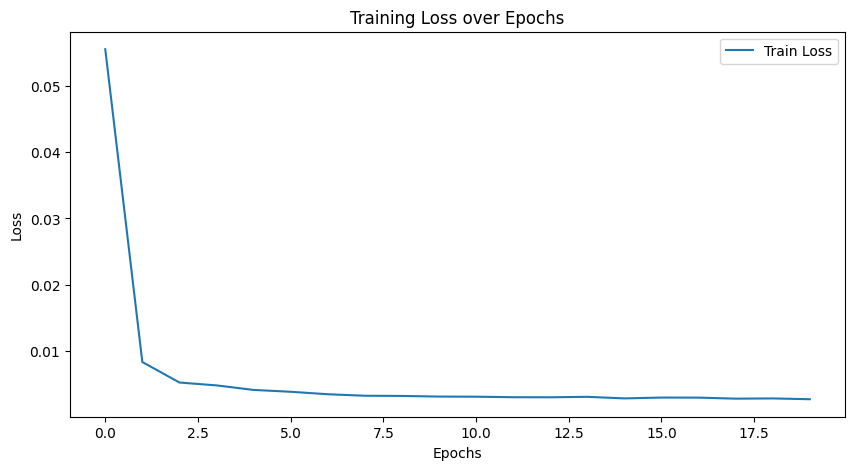

In [ ]:
# Plotting training and validation losses
plt.figure(figsize=(10, 5))
plt.plot(train_losses, label='Train Loss')
plt.title('Training Loss over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

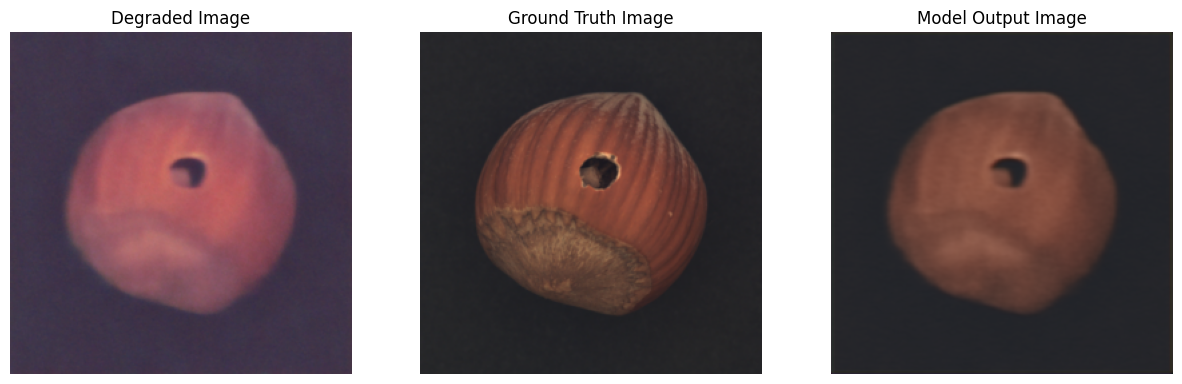

In [ ]:
# Take one image from the train loader
degraded_img, gt_img, class_idx, original_size, subclass_name = next(iter(train_loader))

# Select the first image from the batch for visualization
degraded_img = degraded_img[0].unsqueeze(0)  # Change to (1, C, H, W)
gt_img = gt_img[0].unsqueeze(0)  # Change to (1, C, H, W)

# Get model output for the degraded image
model.eval()  # Set model to evaluation mode
with torch.no_grad():
    model_output = model(degraded_img.to(device), class_idx[0].unsqueeze(0).to(device))  # Pass single image and class index

# Move images to CPU for visualization and change to (H, W, C)
degraded_img_numpy = degraded_img.cpu().detach().numpy()[0].transpose(1, 2, 0)
gt_img_numpy = gt_img.cpu().detach().numpy()[0].transpose(1, 2, 0)
model_output_numpy = model_output.cpu().detach().numpy()[0].transpose(1, 2, 0)

plt.figure(figsize=(15, 5))

# Plot images
for i, (img, title) in enumerate(zip([degraded_img_numpy, gt_img_numpy, model_output_numpy],
                                    ['Degraded Image', 'Ground Truth Image', 'Model Output Image'])):
    plt.subplot(1, 3, i + 1)
    plt.imshow(img)
    plt.title(title)
    plt.axis('off')

plt.show()

In [ ]:
# Function to compute PSNR and SSIM
def compute_metrics(gt_img, model_output, degraded_img=None):
    psnr_value = skimage.metrics.peak_signal_noise_ratio(gt_img, model_output, data_range=1)
    ssim_value = skimage.metrics.structural_similarity(gt_img, model_output, multichannel=True, win_size=3, data_range=1)

    if degraded_img is not None:
        psnr_ref = skimage.metrics.peak_signal_noise_ratio(gt_img, degraded_img, data_range=1)
        ssim_ref = skimage.metrics.structural_similarity(gt_img, degraded_img, multichannel=True, win_size=3, data_range=1)
        return psnr_ref, ssim_ref

    return psnr_value, ssim_value

# Compute metrics for original images
psnr_value, ssim_value = compute_metrics(gt_img_numpy, model_output_numpy)
print(f'PSNR: {psnr_value:.2f} dB')
print(f'SSIM: {ssim_value:.4f}')


# Ensure original_size is a tuple of integers
original_size = (256,256)  # Ensure it's a tuple of integers

# Resize images to their original size
degraded_img_resized = cv2.resize(degraded_img_numpy, original_size)  # Use the tuple directly
model_output_resized = cv2.resize(model_output_numpy, original_size)  # Use the tuple directly
gt_img_resized = cv2.resize(gt_img_numpy, original_size)  # Use the tuple directly

# Compute metrics for resized images
psnr_value_resized, ssim_value_resized = compute_metrics(gt_img_resized, model_output_resized)
print('-'*20)
print(f'Resized PSNR: {psnr_value_resized:.2f} dB')
print(f'Resized SSIM: {ssim_value_resized:.4f}')

# Compute reference metrics if degraded image is provided
psnr_ref_resized, ssim_ref_resized = compute_metrics(gt_img_resized, model_output_resized, degraded_img_resized)
print('-'*20)
print(f'Reference PSNR val: {psnr_ref_resized:.2f} dB')
print(f'Reference SSIM val: {ssim_ref_resized:.4f}')

PSNR: 32.96 dB
SSIM: 0.9555
--------------------
Resized PSNR: 32.96 dB
Resized SSIM: 0.9555
--------------------
Reference PSNR val: 18.35 dB
Reference SSIM val: 0.6189
